# Tarea 2

Integrantes:
- Sara Sofía Rivera Sanabria.
- Juan Sebastián Rueda Segura.
- Santiago Rocha Pachón.

In [1]:
!pip install matplotlib numpy scipy

## Funciones y clases auxiliares

In [4]:

#TODO: Consider making random_init and diag_init class methods
#TODO: Add blank_init, can be found in H1

In [11]:
import copy

import matplotlib.pyplot as plt
import numpy as np

"""
Implementation of a configuration from some configuration space. It contains
its vertices represented as a list of strings, where each string is a key of
the color dictionary; and a mapping from each vertex to its neighbors, i.e.,
the edges from each vertex to its neighbors
"""
class Config:
    def __init__(self, V: list[str], E: dict, color_dict: dict):
        self.V: list[str] = V #*Vertices
        self.E: dict = E
        self.E_list: list = None
        self.color_dict: dict = color_dict

    def deep_copy(self) -> "Config":
        """
        Create a deep copy of this Config object.
        
        Returns
        -------
        Config
            A new Config object that is a deep copy of this one, ensuring
            no shared references between the original and the copy.
        """
        return Config(
            V=copy.deepcopy(self.V),
            E=copy.deepcopy(self.E),
            color_dict=copy.deepcopy(self.color_dict)
        )

    def get_edges_list(self) -> list[list]:
        """
        Make a list of unique edges (pair of vertices id) based on the
        vertex -> neighbors map E.
        """
        E_set: set = set()
        for current, neighbors in self.E.items():
            for neighbor in neighbors:
                E_set.add(tuple(sorted([current, neighbor])))
        return list(E_set)

    def graph(self) -> None:
        """
        Graph this Config in a square-like arrangement of its vertices.
        It expects the Config to have a number of vertices (in V) that is a
        square number, otherwise, it raises an error.
        """
        #*Check if V has a square number of elements
        if int(len(self.V) ** (1/2)) * int(len(self.V) ** (1/2)) != len(self.V):
            raise ValueError(f"V must have a square number of elements, but it has {len(self.V)}")

        n: int = int(len(self.V) ** (1/2))

        #*Convert array-like M to np array
        V_as_lol: list[list[str]] = []
        for i in range(n):
            V_as_lol.append(self.V[i*n: (i + 1)*n])
        # import pdb; pdb.set_trace()
        V_as_nparr: np.array = np.asarray(V_as_lol)
        rows, cols = V_as_nparr.shape

        #*Instantiate plot
        fig, ax = plt.subplots(figsize=(cols, rows))

        #*Set up coordinate system (fitting grid)
        ax.set_xlim(-0.5, cols - 0.5)
        ax.set_ylim(rows - 0.5, -0.5)
        ax.set_xticks(np.arange(0, cols))
        ax.set_yticks(np.arange(0, rows))

        #*Hide tick marks and labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

        #*Add edges
        if self.E_list is None:
            self.E_list = self.get_edges_list()
        E_list = self.E_list
        
        for edge in E_list:
            vertex1_id, vertex2_id = edge
            #*Convert vertex ID to (row, col) coordinates
            row1, col1 = vertex1_id // n, vertex1_id % n
            row2, col2 = vertex2_id // n, vertex2_id % n
            #*Plot line between the two vertices (col for x-axis, row for y-axis)
            ax.plot([col1, col2], [row1, row2], linewidth=2, color='black', alpha=0.7)

        #*Calculate size of the circles (particles) depending on the size of M
        cell_width_pts = (fig.get_figwidth() * 72) / max(cols, 1)
        cell_height_pts = (fig.get_figheight() * 72) / max(rows, 1)
        node_size = (0.35 * min(cell_width_pts, cell_height_pts)) ** 2

        #*Plot circles
        for row in range(rows):
            for col in range(cols):
                value = V_as_nparr[row, col]
                if isinstance(value, np.generic):
                    value = value.item()
                facecolor = self.color_dict[value]
                ax.scatter(col, row, s=node_size, c=facecolor, edgecolors='black', zorder=3)

        ax.set_aspect("equal") #*square proportions
        plt.show()

    def get_neighbors(self, vertex_id: int) -> list[int]:
        """
        Return a list of the neighbors'id (i.e., their index in V) of
        V[vertex_id]
        """
        return self.E[vertex_id]

    def is_feasible(self, E: dict = None) -> bool:
        """
        Return True if this configuration is feasible (i.e., no vertex has
        any of the colors of its neighbors) or False if it is not, depending
        on the given neighbor mapping.

        Parameters
        ----------
        - E (dict, optional): The mapping vertex -> neighbors to check the
        feasibility of the configuration on. Defaults to using self's E.
        """
        if E == None:
            E_mapping: dict = self.E
        else:
            E_mapping: dict = E
        for vertex_id, neighbors in E_mapping.items():
            current_vertex_color: str = self.V[vertex_id] #*it is actually the color's key
            for neighbor_id in neighbors:
                neighbor_color: str = self.V[neighbor_id] #*it is actually the color's key
                if current_vertex_color == neighbor_color:
                    return False
        return True

    def is_other_feasible(self, other: "Config") -> bool:
        """
        Return True if `other` is feasible using this Config's
        vertex -> neighbors mapping (E)

        Parameters
        ----------
        other (Config): The Config to check the feasibility of.
        """
        return other.is_feasible(self.E)
    
    def n_possible_q_colorations(self) -> int:
        """
        Return the number of q-colorations (feasible or not) that can be created
        from this `Config`s `E`, `V` and `color_dict`.
        """
        return len(self.color_dict)**len(self.V)
    
    def _build_grid_from_V(self, V: list[str]) -> list[list[str]]:
        """
        Construct a list of (disjoint) lists that store, together, the same number of elements as V. V's lenght must be square.
        """
        #*Check if V has a square number of elements
        if int(len(V) ** (1/2)) * int(len(V) ** (1/2)) != len(V):
            raise ValueError(f"V must have a square number of elements, but it has {len(V)}")
        
        k_root = int(len(V) ** (1/2))
        V_matrix: list[list[str]] = []
        for n in range(k_root):
            V_row: list[str] = []
            for m in range(k_root):
                V_row.append(V[n*k_root + m])
            V_matrix.append(V_row)

        return V_matrix
    
    def _build_V_from_grid(self, V_grid: list[list[str]] | np.ndarray) -> list[str]:
        if isinstance(V_grid, list):
            V: list[str] = []
            for row in V_grid:
                V += row
            return V
        elif isinstance(V_grid, np.ndarray):
            return V_grid.flatten().tolist()
        else:
            raise TypeError(f"V_grid must be a list or numpy array, got {type(V_grid)}")
            

    def random_init(self, V_size: int = 1) -> "Config":
        conf = self.deep_copy()
        colors: list = list(conf.color_dict.keys())
        conf.V = np.random.choice(colors, size=V_size)
        return conf
    
    def diagonal_init(self, V_size = 1) -> "Config":
        conf = self.deep_copy()
        colors = list(conf.color_dict.keys())
        grid_size: int = int(V_size ** (1/2))
        grid = [[0 for _ in range(grid_size)] for _ in range(grid_size)]
        for i in range(grid_size):
            for j in range(grid_size):
                # import pdb; pdb.set_trace()
                grid[i][j] = colors[(i + j) % len(colors)]
        conf.V = conf._build_V_from_grid(grid)
        return conf


    def gibbs_sampler_q_coloration(self, iterations: int) -> "Config":
        """
        Pick a random initial configuration and perform Gibbs' sampling to color the grid.
        The Gibbs sampler picks a random cell and reassigns it a color that does not violate the coloring constraints.
        """
        
        def _valid_colors(x_idx, config: Config) -> list:
            """ 
            Given a position (x, y) (interpret it as a vertex if you wish) in the grid, return the list of colors that can be assigned to that position without violating the coloring constraints.
            """
            try:
                neighbors = config.E[x_idx]
                not_valid_colors: list[str] = [self.V[neighbor] for neighbor in neighbors]
                # print("Not valid colors:", not_valid_colors)
                return [col for col in list(self.color_dict.keys()) if col not in not_valid_colors]
            except BaseException as e:
                # print("Exception:", e)
                return list(self.color_dict.keys())

        result = self
        for _ in range(iterations):
            # (x, y) = np.random.randint(0, grid_size, size=2)
            v_idx = np.random.randint(0, len(result.V))
            valid_colors = _valid_colors(v_idx, result)
            # import pdb; pdb.set_trace()
            # print("Valid colors:", valid_colors)
            # print(v_idx, result.V)
            if valid_colors:
                result.V[v_idx] = np.random.choice(valid_colors)
            # result.graph()

        return result
        


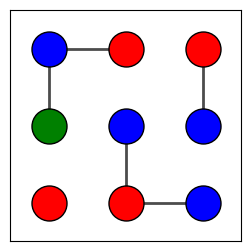

---


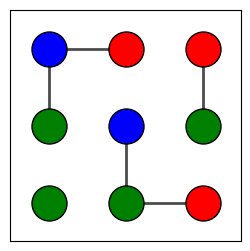

True
Possible 3-colorations in a 3x3 grid: 19683


In [12]:
#*Example use of Config
conf: Config = Config(V=['r', 'g', 'b', 'g', 'b', 'r', 'g', 'r', 'b'],
                      E={0: [1, 3], 2: [3], 7: [5, 8]},
                      color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf2: Config = Config(V=['r', 'g', 'b', 'g', 'b', 'r', 'g', 'r', 'b'],
                      E={0: [1, 3], 2: [1], 7: [4, 8]},
                      color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf3: Config = Config(V=[], E={0: [1, 3], 1: [0], 2: [5], 3: [0], 4: [7], 5: [2] , 7: [4, 8], 8: [7]}, color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
conf4 = conf3.random_init(V_size=9)
conf5 = conf3.diagonal_init(V_size=9)
conf6 = conf4.gibbs_sampler_q_coloration(100) #corre 100 iteraciones

# conf5.graph()
# print(conf5.is_feasible())
conf4.graph()
print("---")
conf6 = conf4.gibbs_sampler_q_coloration(20)
conf6.graph()
print(conf6.is_feasible())
# conf4.graph()
# conf2.graph()
# conf.graph()

print("Possible 3-colorations in a 3x3 grid:", conf.n_possible_q_colorations())

## Aproximación del número de q-coloraciones

### Gibbs sampler for q-coloration

In [2]:
from math import log

def estimate_n_q_colorations(k: int = 9, epsilon: float = 0.01, p: float = 1/3, color_dict: dict = {'b': 'negro', 'w': 'blanco'}, verbose: bool = True) -> float:
    """
    This function estimates the number of feasible q-colorations in a graph
    G = (V, E) with probability `p` of the estimate Z_l being in the interval [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}].
     
    The graph G = (V, E) will be built with |V| = `k` vertices and |E| = 2*√`k` * (√`k` - 1) edges, and forcing each vertex to have degree 2, 3 or 4. A visual representation of the graph the function is expected to work with is shown below:
    ```
    a--b--c
    |  |  |
    d--e--f
    |  |  |
    g--h--j
    ```
    when `k` = 9.

    The algorithm does the following:
    For 0 <= i <= l-1,
        1. Instantiates a `Config` of Z_i called to as `base_config`. Just like its name implies, it is used in the next for loop to instantiate random `Config`s.
        2. Appends the next edge to `current_next_E`, i.e., adds the first vertex to the list of neighbors of the second one and viceversa. `current_next_E` is therefore E_{i+1}
        3. For each m in range(0, (16*|E|)/(`p` * `epsilon`^2)):
            3.1. Creates a `Config` of Z_i (for reference, see Notes) using k * (log(k) + log(8/(`epsilon`l)) - log(d))/ log(q / (2d^2)) steps of Gibbs' random sampler.
            3.2. Checks whether it is feasible using `is_feasible` and `current_next_E`. If it is, adds 1 to `feasible_count`, and either way, increases `total_count` by 1 too.
        4. Appends `feasible_count / total_count` to `estimates`.
    Finally, returns the list of quotient estimates and Z_0 and the product of the elements in the list.

    Parameters
    ----------
    - k : int, optional
        Number of vertices in the graph. Must be a square number. Default is 9.
    - epsilon : float, optional
        Precision of the algorithm. With probability `p`, the product of the 
        estimates will be in the range [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}]. 
        Default is 0.01.
    - p : float, optional
        Probability that the product of estimates will be in the range 
        [(1 - `epsilon`)Z_{G, q}, (1 + `epsilon`)Z_{G, q}]. Default is 1/3.
    - color_dict : dict, optional
        Mapping key => color, where key will be a possible element of V 
        (a color any vertex may take) and color its respective color to be used 
        when graphing. Default is {'b': 'negro', 'w': 'blanco'}.
    - verbose: bool, optional
        Whether to show the three products of the total number of iterations required
        for the algorithm to work and the estimates as they are calculated.

    Returns
    -------
    (list[float], float)
        A tuple containing a list of the estimates used, and their product as a float.
        
    Notes
    -----

    Builds the graph Z_i, where Z_i = (V, E_i), and E_i = E_{i - 1} U {(x_i, y_i)} with x_i, y_i in V. For each increment in i, an edge is supposed to be added between two vertices. It will start adding the horizontal ones followed by the vertical ones. An example is shown below:
    ```
    a--b--c             a--b--c             a--b--c
                                            |
    d--e--f     =>      d--e--f     =>      a--b--c

    g--h  j             g--h--j             a--b--c

      Z_5                 Z_6                 Z_7
    ```
    when `k` = 9
    """
    if int(k ** (1/2)) * int(k ** (1/2)) != k:
        raise ValueError(f"V must have a square number of elements, but it has {k}")
    #*0) Define helper variables
    k_root: int = int(k**(1/2))
    total_edges: int = 2*k_root*(k_root - 1)
    q: int = len(color_dict)
    gibbs_iterations: int = k * ((2*log(k) + log(8) + log(1/epsilon))/(1)) #!The denominator should be q/2*16 = q/2d^2, but it yields negative numbers that way, so it will be left as 1
    # print(log(q/32))
    estimates: list[float] = [q**k] #*add Z_0

    #*1) Build E (all the edges) as a list of tuples of indices of V
    #TODO: Create a function that builds E as a mapping of vertex to neighbors in is_feasible or in Config itself
    E_list: list[str] = []
    for c in range(k_root):
        for b in range(k_root - 1):
            E_list.append((c*k_root + b, c*k_root + b + 1))
    for c in range(k_root - 1):
        for b in range(k_root):
            E_list.append((c * k_root + b, (c + 1) * k_root + b))
    
    if verbose:
        print("Len E:", len(E_list))

    #*2) Estimate each Z_i / Z_{i-1}
    feasible_count: int = 0
    total_count: int = 0
    current_next_E: dict = {} #*E_{i+1}
    if verbose:
        print(total_edges, int((16*total_edges)/(p * epsilon**2)), gibbs_iterations)
    for i in range(0, total_edges):
        feasible_count = 0
        total_count = 0
        #*2.1) Create the initial configuration of Z_{i}
        base_conf: Config = Config([], current_next_E, color_dict)
        base_conf = base_conf.random_init(V_size=k)
        #*2.2) Consider E_{i+1}
        try:
            current_next_E[E_list[i][0]].append(E_list[i][1])
        except KeyError:
            current_next_E[E_list[i][0]] = [E_list[i][1]]
        try:
            current_next_E[E_list[i][1]].append(E_list[i][0])
        except KeyError:
            current_next_E[E_list[i][1]] = [E_list[i][0]]
        if verbose:
            print("E:", current_next_E)
        for m in range(int((16*total_edges)/(p * epsilon**2))):
            conf: Config = base_conf.random_init(V_size=k)
            conf = conf.gibbs_sampler_q_coloration(int(gibbs_iterations))
            #*2.3) After running Gibbs' sampler from base_conf, determines whether it is feasible in Z_{i+1}
            # if m == 50:
            #     conf2 = Config(conf.V, current_next_E, conf.color_dict)
            #     conf2.graph()
            #     print(conf.is_feasible(current_next_E))
            if conf.is_feasible(current_next_E):
                feasible_count += 1
            total_count += 1
        if verbose:
            print(f"{feasible_count} / {total_count}, for Z_{i+1} / Z_{i}")
        estimates.append(feasible_count / total_count)

    #*3) Return the product estimate along with the list of all estimates and Z_0
    prod_estimate: float = 1
    for estimate in estimates:
        prod_estimate *= estimate
    
    return [estimates, prod_estimate]

In [104]:
estimates, z_estimate = estimate_n_q_colorations(k=9, epsilon=0.1, p=5/6, color_dict={'r': 'red', 'b': 'blue', 'g': 'green'})
z_estimate

Len E: 12
12 23039 78.98828210411689
E: {0: [1], 1: [0]}
15313 / 23039, for Z_1 / Z_0
E: {0: [1], 1: [0, 2], 2: [1]}
15394 / 23039, for Z_2 / Z_1
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3]}
15408 / 23039, for Z_3 / Z_2
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4]}
15379 / 23039, for Z_4 / Z_3
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4], 6: [7], 7: [6]}
15435 / 23039, for Z_5 / Z_4
E: {0: [1], 1: [0, 2], 2: [1], 3: [4], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
15350 / 23039, for Z_6 / Z_5
E: {0: [1, 3], 1: [0, 2], 2: [1], 3: [4, 0], 4: [3, 5], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
15365 / 23039, for Z_7 / Z_6
E: {0: [1, 3], 1: [0, 2, 4], 2: [1], 3: [4, 0], 4: [3, 5, 1], 5: [4], 6: [7], 7: [6, 8], 8: [7]}
17213 / 23039, for Z_8 / Z_7
E: {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0], 4: [3, 5, 1], 5: [4, 2], 6: [7], 7: [6, 8], 8: [7]}
17214 / 23039, for Z_9 / Z_8
E: {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0, 6], 4: [3, 5, 1], 5: [4, 2], 6: [7, 3], 7: [6,

181.7985939643443

In [106]:
z_estimate / 3**9

0.009236325456706005

In [1]:
# config = Config([], {0: [1, 3], 1: [0, 2, 4], 2: [1, 5], 3: [4, 0, 6], 4: [3, 5, 1, 7], 5: [4, 2], 6: [7, 3], 7: [6, 8, 4], 8: [7]}, {'r': 'red', 'b': 'blue', 'g': 'green'})
# config = config.diagonal_init(9)
# config.graph()

## Comparación con Conteo Exacto

In [8]:
pip install networkx sympy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Primer approach recursivo

In [ ]:
import networkx as nx
from sympy import symbols, expand

def create_grid_graph(k):
    """
    Crea una rejilla K x K como grafo de NetworkX.
    """
    G = nx.grid_2d_graph(k, k)
    mapping = {(i, j): i * k + j for i in range(k) for j in range(k)}
    G = nx.relabel_nodes(G, mapping)
    return G

def chromatic_polynomial_recursive(G):
    """
    Calcula el polinomio cromático recursivamente usando eliminación-contracción.
    """
    q = symbols('q')

    # Condiciones base:
    if G.number_of_edges() == 0:
        # Si no hay aristas, cada vértice puede colorearse de q formas
        return q ** G.number_of_nodes()

    if G.number_of_nodes() == 1:
        return q

    # Elige una arista cualquiera
    u, v = list(G.edges())[0]

    # G - e
    G_minus = G.copy()
    G_minus.remove_edge(u, v)

    # G / e (contracción)
    G_contract = nx.contracted_edge(G, (u, v), self_loops=False)

    # Aplicar recursión
    return expand(chromatic_polynomial_recursive(G_minus) - chromatic_polynomial_recursive(G_contract))

def count_q_colorations_exact(k, q_value):
    """
    Cuenta exactamente el número de q-coloraciones de una rejilla KxK.
    """
    G = create_grid_graph(k)
    poly = chromatic_polynomial_recursive(G)
    q = symbols('q')
    return int(poly.subs(q, q_value))

# Ejemplo:
print(count_q_colorations_exact(2, 3))


18


In [27]:
count_q_colorations_exact(3, 3)

246

In [29]:
count_q_colorations_exact(3, 4)

9612

In [30]:
count_q_colorations_exact(4, 3)

7812

---

segundo metodo con networkx.algorithms.polynomials

In [ ]:
import networkx as nx
from networkx.algorithms.polynomials import chromatic_polynomial
import numpy as np
from sympy import Symbol

def exact_q_colorations_count(k: int = 3, q: int = 3) -> int:
    """
    Calcula el número exacto de q-coloraciones válidas en una rejilla de tamaño k×k
    utilizando el polinomio cromático.
    
    """
    
    G = nx.grid_2d_graph(k, k)
    x = Symbol('x')
    # Calcular el polinomio cromatico
    poly = chromatic_polynomial(G)
    
    # Evaluar el polinomio en q
    exact_count = int(poly.subs(x, q))
    
    return exact_count



In [ ]:
exact = exact_q_colorations_count(k=3, q=3)
print(f"Número exacto de 3-coloraciones en rejilla 3x3: {exact}")


Número exacto de 3-coloraciones en rejilla 3×3: 246


In [ ]:
exact2 = exact_q_colorations_count(k=4, q=3)
print(f"Número exacto de 3-coloraciones en rejilla 4x4: {exact2}")

Número exacto de 3-coloraciones en rejilla 4×4: 7812


In [ ]:
def compare_exact_vs_approximate(k: int = 3, q: int = 3, epsilon: float = 0.1, 
                                 p: float = 5/6, verbose: bool = True) -> dict:
    """
    Compara el conteo exacto usando el polinomio cromático con la aproximación MCMC.
    
    Parameters
    ----------
    k : int, optional
        Tamaño de la rejilla. Default es 3.
    q : int, optional
        Número de colores. Default es 3.
    epsilon : float, optional
        Precisión para el algoritmo de aproximación. Default es 0.1.
    p : float, optional
        Probabilidad de que la estimación esté en el rango deseado. Default es 5/6.
    verbose : bool, optional
        Si se debe imprimir información adicional durante la ejecución. Default es True.
    
    Returns
    -------
    dict
        Diccionario con los resultados de ambos métodos y métricas de comparación.
    """
    
    
    exact_count = exact_q_colorations_count(k, q)
    
    # Construir el diccionario de colores según q
    if q == 2:
        color_dict = {'b': 'blue', 'r': 'red'}
    elif q == 3:
        color_dict = {'r': 'red', 'b': 'blue', 'g': 'green'}
    elif q == 4:
        color_dict = {'r': 'red', 'b': 'blue', 'g': 'green', 'y': 'yellow'}
    else:
        # Generar diccionario automáticamente para más colores
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown']
        color_dict = {chr(97 + i): colors[i % len(colors)] for i in range(q)}
    
    # Calcular la aproximación usando la función existente
    estimates, approximate_count = estimate_n_q_colorations(
        k=k*k, 
        epsilon=epsilon, 
        p=p, 
        color_dict=color_dict,
        verbose=False
    )
    
    # Calcular métricas de comparación
    absolute_error = abs(exact_count - approximate_count)
    relative_error = absolute_error / exact_count
    ratio = approximate_count / exact_count
    
    results = {
        'k': k,
        'q': q,
        'exact_count': exact_count,
        'approximate_count': approximate_count,
        'absolute_error': absolute_error,
        'relative_error': relative_error,
        'percentage_error': relative_error * 100,
        'ratio_approx_to_exact': ratio,
        'epsilon': epsilon,
        'probability': p
    }
    
    if verbose:
        print(f"\nResultados:")
        print(f"{'='*60}")
        print(f"Tamaño de rejilla: {k}×{k}")
        print(f"Número de colores (q): {q}")
        print(f"\nConteo exacto (polinomio cromático): {exact_count:,.0f}")
        print(f"Conteo aproximado (MCMC): {approximate_count:,.2f}")
        print(f"\nError absoluto: {absolute_error:,.2f}")
        print(f"Error relativo: {relative_error:.4f} ({relative_error*100:.2f}%)")
        print(f"Razón (aproximado/exacto): {ratio:.4f}")
        print(f"{'='*60}")
    
    return results

## 2. Aproximación del Número de Configuraciones del Modelo Hard-Core

La lógica es muy similar al tratar el problema de las q-coloraciones. Simplemente deebemos redefinir si una configuración es factible.

In [13]:
class Config_HardCore(Config):
    def __init__(self, V: list[str], E: dict):
        super().__init__(V, E, {"b": "black", "w": "white"})
    
    def is_feasible(self, E: dict = None) -> bool:
        """
        Return True if this configuration is feasible (i.e., no two adjacent vertices are both 'b') or False if it is not, depending
        on the given neighbor mapping.

        Parameters
        ----------
        - E (dict, optional): The mapping vertex -> neighbors to check the
        feasibility of the configuration on. Defaults to using self's E.
        """
        if E == None:
            E_mapping: dict = self.E
        else:
            E_mapping: dict = E
        for vertex_id, neighbors in E_mapping.items():
            current_vertex_color: str = self.V[vertex_id] #*it is actually the color's key
            if current_vertex_color == 'b':
                for neighbor_id in neighbors:
                    neighbor_color: str = self.V[neighbor_id] #*it is actually the color's key
                    if neighbor_color == 'b':
                        return False
        return True
    
    def deep_copy(self) -> "Config_HardCore":
        """
        Create a deep copy of this Config_HardCore object.
        
        Returns
        -------
        Config_HardCore
            A new Config_HardCore object that is a deep copy of this one, ensuring
            no shared references between the original and the copy.
        """
        return Config_HardCore(
            V=copy.deepcopy(self.V),
            E=copy.deepcopy(self.E),
        )
    
    
    def white_init(self, V_size: int = 1) -> "Config_HardCore":
        conf = self.deep_copy()
        conf.V = ['w' for _ in range(V_size)]
        return conf
    
    def diagonal_init(self, V_size = 1) -> "Config_HardCore":
        conf = self.deep_copy()
        grid_size: int = int(V_size ** (1/2))
        grid = [['w' for _ in range(grid_size)] for _ in range(grid_size)]
        for i in range(grid_size):
            for j in range(grid_size):
                if (i + j) % 2 == 0:
                    grid[i][j] = 'b'
        conf.V = conf._build_V_from_grid(grid)
        return conf
    
    def gibbs_sampler_hard_core(self, iterations: int) -> "Config_HardCore":
        """
        Pick a random initial configuration and perform Gibbs' sampling to color the grid.
        The Gibbs sampler picks a random cell and reassigns it a color that does not violate the hard-core constraints.
        """
        
        def _valid_colors(x_idx, config: Config) -> list:
            """ 
            Given a position (x, y) (interpret it as a vertex if you wish) in the grid, return the list of colors that can be assigned to that position without violating the coloring constraints.
            """
            try:
                neighbors = config.E[x_idx]
                not_valid_colors: list[str] = [self.V[neighbor] for neighbor in neighbors]
                # print("Not valid colors:", not_valid_colors)
                return ["w"] if 'b' in not_valid_colors else ['b', 'w']
            except BaseException as e:
                # print("Exception:", e)
                return ['b', 'w']
        
        result = self
        for _ in range(iterations):
            v_idx = np.random.randint(0, len(result.V))
            rand_val = np.random.rand()
            valid_color = _valid_colors(v_idx, self)
            if rand_val < 0.5:
                if valid_color == ['b', 'w']:
                    result.V[v_idx] = 'b'
                else:
                    result.V[v_idx] = 'w'
            else:
                result.V[v_idx] = 'w'
            
            # temp = Config_HardCore(self._build_V_from_grid(V_grid), copy.deepcopy(self.E))
            # temp.graph()

        return result

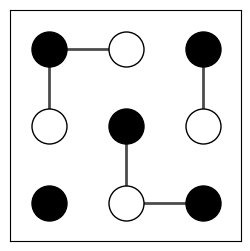

True


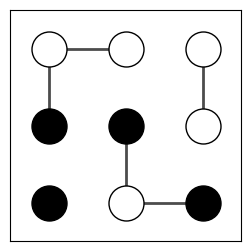

True


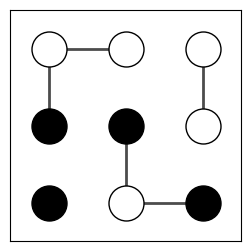

True


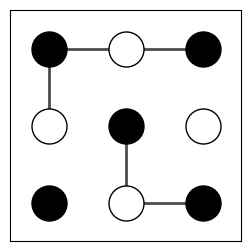

True


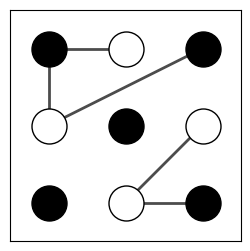

True
Possible Hard-Core configurations in a 3x3 grid: 512


In [14]:
#Example use of Config_HardCore
conf_hc: Config_HardCore = Config_HardCore(V=['b', 'w', 'b', 'w', 'b', 'w', 'b', 'w', 'b'],
                      E={0: [1, 3], 2: [3], 7: [5, 8]})
conf_hc2: Config_HardCore = Config_HardCore(V=['b', 'w', 'b', 'w', 'b', 'w', 'b', 'w', 'b'],
                        E={0: [1, 3], 2: [1], 7: [4, 8]})
conf_hc3: Config_HardCore = Config_HardCore(V=[], E={0: [1, 3], 2: [5], 7: [4, 8]})
conf_hc4 = conf_hc3.random_init(V_size=9)
conf_hc5 = conf_hc3.diagonal_init(V_size=9)
conf_hc6 = conf_hc4.gibbs_sampler_hard_core(100)
conf_hc5.graph()
print(conf_hc5.is_feasible())
conf_hc6.graph()
print(conf_hc6.is_feasible())
conf_hc4.graph()
print(conf_hc4.is_feasible())
conf_hc2.graph()
print(conf_hc2.is_feasible())
conf_hc.graph()
print(conf_hc.is_feasible())

print("Possible Hard-Core configurations in a 3x3 grid:", conf_hc.n_possible_q_colorations())



In [15]:
def estimate_n_hard_core_configurations(k: int = 9, num_simulations: int = 100, num_gibbs_steps: int = 1000, verbose: bool = True) -> float:
    """
    This function estimates the number of feasible configurations in a graph
    G = (V, E) with probability `p` of the estimate Z_l being in the interval [(1 - `epsilon`)Z_{G}, (1 + `epsilon`)Z_{G}].
     
    The graph G = (V, E) will be built with |V| = `k` vertices and |E| = 2*√`k` * (√`k` - 1) edges, and forcing each vertex to have degree 2, 3 or 4. A visual representation of the graph the function is expected to work with is shown below:
    ```
    a--b--c
    |  |  |
    d--e--f
    |  |  |
    g--h  j
    ```
    when `k` = 9.

    The algorithm does the following:
    For 0 <= i <= l-1,
        1. Instantiates a `Config_HardCore` of Z_i called to as `base_config`. Just like its name implies, it is used in the next for loop to instantiate random `Config_HardCore`s.
        2. Appends the next edge to `current_next_E`, i.e., adds the first vertex to the list of neighbors of the second one and viceversa. `current_next_E` is therefore E_{i+1}
        3. For each m in range(0, num_simulations):
            3.1. Creates a `Config_HardCore` of Z_i (for reference, see Notes) using num_gibbs_steps steps of Gibbs' random sampler.
            3.2. Checks whether it is feasible using `is_feasible` and `current_next_E`. If it is, adds 1 to `feasible_count`, and either way, increases `total_count` by 1 too.
        4. Appends `feasible_count / total_count` to `estimates`.
    Finally, returns the list of quotient estimates and Z_0 and the product of the elements in the list.
    Parameters
    ----------
    - k : int, optional 
        Number of vertices in the graph. Must be a square number. Default is 9.
    - verbose: bool, optional
        Whether to show the three products of the total number of iterations required
        for the algorithm to work and the estimates as they are calculated.
    Returns
    -------
    list[float]
        A list containing the estimated number of feasible configurations for each
        layer of the graph, along with the initial configuration Z_0 and the product
        of the estimates.
    """
    if int(k ** (1/2)) * int(k ** (1/2)) != k:
        raise ValueError(f"V must have a square number of elements, but it has {k}")
    
    #*0) Define helper variables
    k_root: int = int(k**(1/2))
    total_edges: int = 2*k_root*(k_root - 1)
    estimates: list[float] = [2**k] #*add Z_0

    gibbs_iterations = num_gibbs_steps #* k**(1/2)
    
    if verbose:
        print("Gibbs iterations per simulation:", gibbs_iterations)
    
    #*1) Build E (all the edges) as a list of tuples of indices of V
    E_list: list[str] = []
    for c in range(k_root):
        for b in range(k_root - 1):
            E_list.append((c*k_root + b, c*k_root + b + 1))
    for c in range(k_root - 1):
        for b in range(k_root):
            E_list.append((c * k_root + b, (c + 1) * k_root + b))
    
    if verbose:
        print("Len E:", len(E_list))
    
    #*2) Estimate each Z_i / Z_{i-1}
    feasible_count: int = 0
    total_count: int = 0
    current_next_E: dict = {} #*E_{i+1}
    for i in range(0, total_edges):
        feasible_count = 0
        total_count = 0
        #*2.1) Create the initial configuration of Z_{i}
        base_conf: Config_HardCore = Config_HardCore([], current_next_E)
        base_conf = base_conf.white_init(V_size=k)
        #*2.2) Consider E_{i+1}
        try:
            current_next_E[E_list[i][0]].append(E_list[i][1])
        except KeyError:
            current_next_E[E_list[i][0]] = [E_list[i][1]]
        try:
            current_next_E[E_list[i][1]].append(E_list[i][0])
        except KeyError:
            current_next_E[E_list[i][1]] = [E_list[i][0]]
        if verbose:
            print("E:", current_next_E)
            
        for m in range(num_simulations):
            conf: Config_HardCore = base_conf.white_init(V_size=k)
            conf = conf.gibbs_sampler_hard_core(int(gibbs_iterations))
            
            #*2.3) After running Gibbs' sampler from base_conf, determines if the two vertices connected by the new edge have different colors
            if (conf.V[E_list[i][0]] == 'w' and conf.V[E_list[i][1]] == 'w') or (conf.V[E_list[i][0]] == 'b' and conf.V[E_list[i][1]] == 'w') or (conf.V[E_list[i][0]] == 'w' and conf.V[E_list[i][1]] == 'b'):
                feasible_count += 1
            
            # if conf.is_feasible(current_next_E):
            #     feasible_count += 1
            total_count += 1
        if verbose:
            print(f"{feasible_count} / {total_count}, for Z_{i+1} / Z_{i}")
        estimates.append(feasible_count / total_count)

    #*3) Return the product estimate along with the list of all estimates and Z_0
    prod_estimate: float = 1
    for estimate in estimates:
        prod_estimate *= estimate
    
    return [estimates, prod_estimate]
        

In [30]:
hc_estimates, z_hc_estimate = estimate_n_hard_core_configurations(k=1, num_simulations=100, num_gibbs_steps=1000, verbose=False)
print(f"Estimate for k={1}: {z_hc_estimate}")

Estimate for k=1: 2


In [24]:
ks = [4, 9, 16, 25]
for k in ks:
    hc_estimates, z_hc_estimate = estimate_n_hard_core_configurations(k=k, num_simulations=100, num_gibbs_steps=1000, verbose=False)
    print(f"Estimate for k={k}: {z_hc_estimate}")

Estimate for k=4: 7.452
Estimate for k=9: 67.67380820159283
Estimate for k=16: 1111.7818663775868
Estimate for k=25: 54716.50243329876


Reporte:

In [16]:
def estimate_hard_core_multiple_runs(k, simul, gstep, num_runs, verbose=False):
    factibles = []
    
    for _ in range(num_runs):
        new_value = estimate_n_hard_core_configurations(k, simul, gstep, verbose)[1]
        factibles.append(new_value)
    
    avg = np.average(factibles)
    std = np.std(factibles)
    
    return avg, std


configs_number = []
configs_uncert = [] 
def report_run(k, num_runs, simulations_arr = [10, 20, 50], gibbs_steps_arr = [500, 1000, 1000]):  

    for simul in simulations_arr:
        configs_number_arr = []
        configs_uncert_arr = []
    
        for gstep in gibbs_steps_arr:
            avg, std = estimate_hard_core_multiple_runs(k, simul, gstep, num_runs, verbose=False)
            print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
            print(f'Numero de simulaciones: {simul}')
            print(f'Numero de pasos de Gibbs sampler: {gstep}')
            print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
            print()
            configs_number_arr.append(avg)
            configs_uncert_arr.append(std)
            
        configs_number.append(configs_number_arr)
        configs_uncert.append(configs_uncert_arr)

In [18]:
report_run(4, 5)

Dimensión: 2.0 x 2.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 6.7  con desviación estándar de 1.3

Dimensión: 2.0 x 2.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 7.1  con desviación estándar de 1.6

Dimensión: 2.0 x 2.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 7.3  con desviación estándar de 1.3

Dimensión: 2.0 x 2.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 6.9  con desviación estándar de 1.2

Dimensión: 2.0 x 2.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 7.2  con desviación estándar de 0.9

Dimensión: 2.0 x 2.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 7.4  con desviación estándar de 1.8

Dimensión: 2.0 x 2.0
Numero de

In [19]:
report_run(9, 5)

Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 65.5  con desviación estándar de 33.3

Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 77.9  con desviación estándar de 37.7

Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 42.8  con desviación estándar de 29.2

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 62.6  con desviación estándar de 14.9

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 59.6  con desviación estándar de 8.7

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 55.1  con desviación estándar de 10.3

Dimensión: 3.0 x 3.

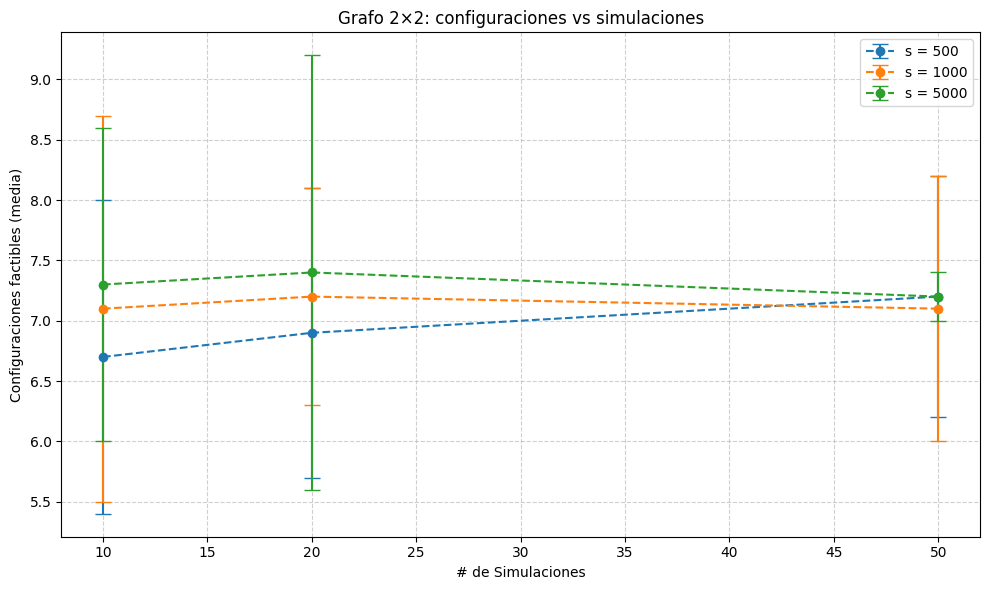

In [ ]:
# Datos 2x2
simulations_arr = np.array([10, 20, 50])

configs_number_2 = np.array([
    [6.7, 6.9, 7.2],      # pasos = 500
    [7.1, 7.2, 7.1],      # pasos = 1000
    [7.3, 7.4, 7.2]       # pasos = 5000
])

configs_uncert_2 = np.array([
    [1.3, 1.2, 1.0],      # pasos = 500
    [1.6, 0.9, 1.1],      # pasos = 1000
    [1.3, 1.8, 0.2]       # pasos = 5000
])

plt.figure(figsize=(10, 6))

plt.errorbar(simulations_arr, configs_number_2[0], yerr=configs_uncert_2[0],
             linestyle='--', marker='o', capsize=6, label='s = 500')
plt.errorbar(simulations_arr, configs_number_2[1], yerr=configs_uncert_2[1],
             linestyle='--', marker='o', capsize=6, label='s = 1000')
plt.errorbar(simulations_arr, configs_number_2[2], yerr=configs_uncert_2[2],
             linestyle='--', marker='o', capsize=6, label='s = 5000')

plt.xlabel('# de Simulaciones')
plt.ylabel('Configuraciones factibles (media)')
plt.title('Grafo 2x2: configuraciones vs simulaciones')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


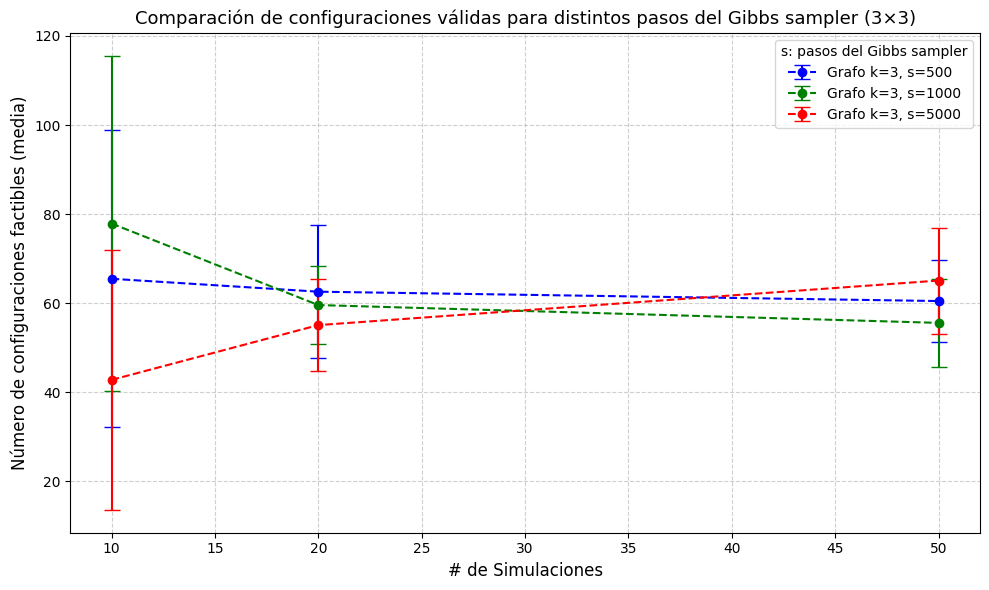

In [ ]:
# Datos del caso 3x3
simulations_arr = np.array([10, 20, 50])

# Medias (número de configuraciones factibles)
configs_number = np.array([
    [65.5, 62.6, 60.5],   # pasos = 500
    [77.9, 59.6, 55.6],   # pasos = 1000
    [42.8, 55.1, 65.1]    # pasos = 5000
])

# Desviaciones estándar correspondientes
configs_uncert = np.array([
    [33.3, 14.9, 9.3],    # pasos = 500
    [37.7, 8.7, 9.8],     # pasos = 1000
    [29.2, 10.3, 11.9]    # pasos = 5000
])

# Crear figura
plt.figure(figsize=(10, 6))

# Graficar cada conjunto de datos con barras de error
plt.errorbar(simulations_arr, configs_number[0], yerr=configs_uncert[0],
             color='blue', linestyle='--', marker='o', capsize=6, label='Grafo k=3, s=500')
plt.errorbar(simulations_arr, configs_number[1], yerr=configs_uncert[1],
             color='green', linestyle='--', marker='o', capsize=6, label='Grafo k=3, s=1000')
plt.errorbar(simulations_arr, configs_number[2], yerr=configs_uncert[2],
             color='red', linestyle='--', marker='o', capsize=6, label='Grafo k=3, s=5000')

# Etiquetas y título
plt.xlabel('# de Simulaciones', fontsize=12)
plt.ylabel('Número de configuraciones factibles (media)', fontsize=12)
plt.title('Comparación de configuraciones válidas para distintos pasos del Gibbs sampler (3x3)', fontsize=13)

# Leyenda y cuadrícula
plt.legend(title='s: pasos del Gibbs sampler')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [21]:
report_run(16, 5)

Dimensión: 4.0 x 4.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 1405.0  con desviación estándar de 757.9

Dimensión: 4.0 x 4.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 2179.2  con desviación estándar de 1157.3

Dimensión: 4.0 x 4.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 1195.4  con desviación estándar de 673.5

Dimensión: 4.0 x 4.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 1107.4  con desviación estándar de 542.3

Dimensión: 4.0 x 4.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 1314.6  con desviación estándar de 760.3

Dimensión: 4.0 x 4.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 1126.7  con desviación estándar de 461.7


KeyboardInterrupt: 

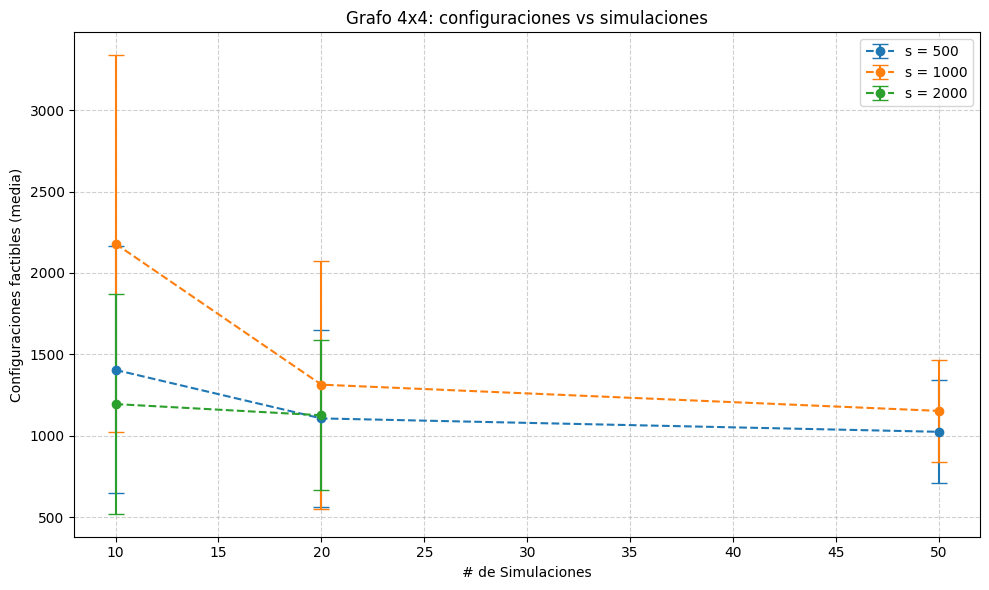

In [13]:
# Datos 4x4
simulations_arr = np.array([10, 20, 50])

configs_number_4 = np.array([
    [1405.0, 1107.4, 1025.2],   # pasos = 500
    [2179.2, 1314.6, 1153.5],   # pasos = 1000
    [1195.4, 1126.7, 1142.6]      # pasos = 2000 
])

configs_uncert_4 = np.array([
    [757.9, 542.3, 316.4],      # pasos = 500
    [1157.3, 760.3, 311.2],     # pasos = 1000
    [673.5, 461.7, 312.1]        # pasos = 2000
])

plt.figure(figsize=(10, 6))

# s = 500
plt.errorbar(simulations_arr, configs_number_4[0], yerr=configs_uncert_4[0],
             linestyle='--', marker='o', capsize=6, label='s = 500')

# s = 1000
plt.errorbar(simulations_arr, configs_number_4[1], yerr=configs_uncert_4[1],
             linestyle='--', marker='o', capsize=6, label='s = 1000')

# s = 2000 (solo dos puntos: simulaciones 10 y 20)
plt.errorbar(simulations_arr[:2], configs_number_4[2][:2], yerr=configs_uncert_4[2][:2],
             linestyle='--', marker='o', capsize=6, label='s = 2000')

plt.xlabel('# de Simulaciones')
plt.ylabel('Configuraciones factibles (media)')
plt.title('Grafo 4x4: configuraciones vs simulaciones')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
sizes = [9, 16, 25, 36]
configs_number_all = []
configs_uncert_all = []

for size in sizes:
    print(f'--- Rejilla {int(size**(1/2))} x {int(size**(1/2))} ---')
    report_run(size, 2)

--- Rejilla 3 x 3 ---
Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 70.9  con desviación estándar de 17.2

Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 32.9  con desviación estándar de 12.3

Dimensión: 3.0 x 3.0
Numero de simulaciones: 10
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 49.0  con desviación estándar de 9.2

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 500
Numero de configuraciones factibles : 51.9  con desviación estándar de 25.0

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 1000
Numero de configuraciones factibles : 82.7  con desviación estándar de 5.0

Dimensión: 3.0 x 3.0
Numero de simulaciones: 20
Numero de pasos de Gibbs sampler: 5000
Numero de configuraciones factibles : 41.0  con desviación estándar de 19.1

KeyboardInterrupt: 

In [8]:
simul = 30
gibbs_steps = 10000
configurations = []
deviation = []
k_values1 = [4,9,16,25,36, 49, 64, 81, 100]


def report_run(k, num_runs):
    avg, std = estimate_hard_core_multiple_runs(k, simul, gibbs_steps, num_runs)
    print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {gibbs_steps*(k)**(1/2)}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
    print()
    configurations.append(avg)
    deviation.append(std)
    
for k in k_values1:
    report_run(k = k, num_runs = 2)

Dimensión: 2.0 x 2.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 20000.0
Numero de configuraciones factibles : 6.7  con desviación estándar de 0.3

Dimensión: 3.0 x 3.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 30000.0
Numero de configuraciones factibles : 72.8  con desviación estándar de 6.8

Dimensión: 4.0 x 4.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 40000.0
Numero de configuraciones factibles : 1444.8  con desviación estándar de 406.6

Dimensión: 5.0 x 5.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 50000.0
Numero de configuraciones factibles : 64295.9  con desviación estándar de 3028.8

Dimensión: 6.0 x 6.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 60000.0
Numero de configuraciones factibles : 5525527.3  con desviación estándar de 327075.2

Dimensión: 7.0 x 7.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 70000.0
Numero de configuraciones factibles : 1443558047.5  con desvi

KeyboardInterrupt: 

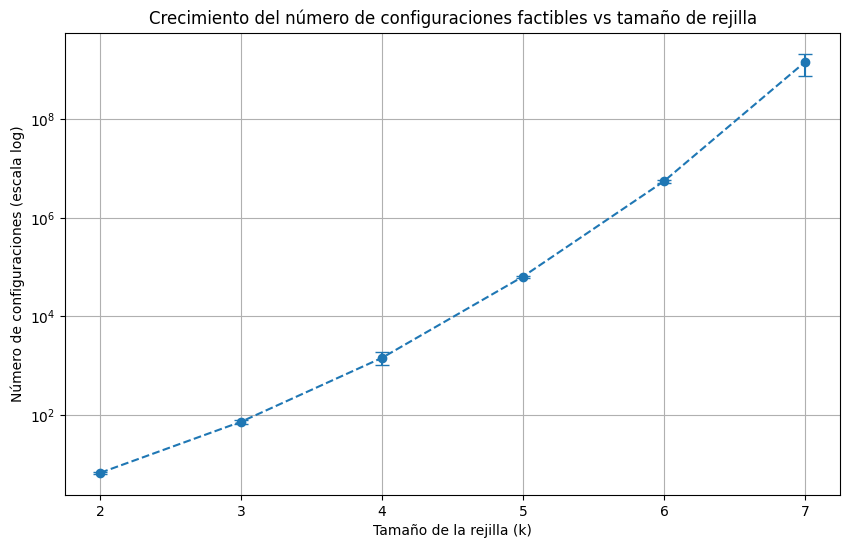

In [ ]:
# Datos
k = np.array([2, 3, 4, 5, 6, 7])
configs = np.array([6.7, 72.8, 1444.8, 64295.9, 5525527.3, 1443558047.5])
std = np.array([0.3, 6.8, 406.6, 3028.8, 327075.2, 692371490.3])

plt.figure(figsize=(10, 6))

plt.errorbar(k, configs, yerr=std, fmt='o--', capsize=5)
plt.yscale("log")

plt.xlabel("Tamaño de la rejilla (kxk)")
plt.ylabel("Número de configuraciones")
plt.title("Crecimiento del número de configuraciones factibles vs tamaño de rejilla")
plt.grid(True)

plt.show()


In [19]:
simul = 30
gibbs_steps = 10000
configurations = []
deviation = []
k_values1 = [64, 81, 100, 121]


def report_run(k, num_runs):
    avg, std = estimate_hard_core_multiple_runs(k, simul, gibbs_steps, num_runs)
    print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {gibbs_steps}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
    print()
    configurations.append(avg)
    deviation.append(std)
    
for k in k_values1:
    report_run(k = k, num_runs = 1)

Dimensión: 8.0 x 8.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 951286414073.8  con desviación estándar de 0.0

Dimensión: 9.0 x 9.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 189030653966917.5  con desviación estándar de 0.0

Dimensión: 10.0 x 10.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 691599757640581120.0  con desviación estándar de 0.0

Dimensión: 11.0 x 11.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 2373482165990338330624.0  con desviación estándar de 0.0



In [17]:
simul = 30
gibbs_steps = 10000
configurations = []
deviation = []
k_values1 = [144, 169, 196, 225, 256, 289, 324, 361, 400]


def report_run(k, num_runs):
    avg, std = estimate_hard_core_multiple_runs(k, simul, gibbs_steps, num_runs)
    print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {gibbs_steps}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
    print()
    configurations.append(avg)
    deviation.append(std)
    
for k in k_values1:
    report_run(k = k, num_runs = 1)

Dimensión: 12.0 x 12.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 28196615817169509252333568.0  con desviación estándar de 0.0

Dimensión: 13.0 x 13.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 4311425132096001172574641848320.0  con desviación estándar de 0.0

Dimensión: 14.0 x 14.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 1331661159409247708564178020702617600.0  con desviación estándar de 0.0

Dimensión: 15.0 x 15.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 13795976302719700716009855382427361345536.0  con desviación estándar de 0.0

Dimensión: 16.0 x 16.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 10000
Numero de configuraciones factibles : 4342445819037929392168084276763162196085571584.0  con desviación estándar de 0.0


KeyboardInterrupt: 

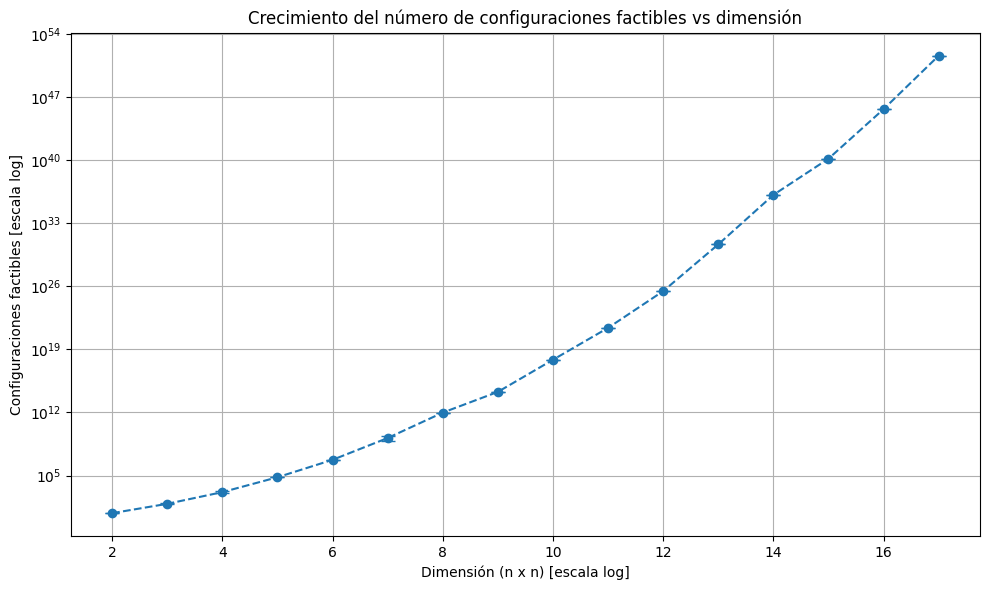

In [19]:
# --------------------------
# Datos proporcionados
# --------------------------

dims = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

configs = np.array([
    6.7,
    72.8,
    1444.8,
    64295.9,
    5525527.3,
    1443558047.5,
    951286414073.8,
    189030653966917.5,
    691599757640581120.0,
    2373482165990338330624.0,
    28196615817169509252333568.0,
    4311425132096001172574641848320.0,
    1331661159409247708564178020702617600.0,
    13795976302719700716009855382427361345536.0,
    4342445819037929392168084276763162196085571584.0,
    3656163057787922622073184300941275159087479259136000.0
])

uncert = np.array([
    0.3,
    6.8,
    406.6,
    3028.8,
    327075.2,
    692371490.3,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0
])

# --------------------------
# Gráfica log-log
# --------------------------

plt.figure(figsize=(10,6))
plt.errorbar(dims, configs, yerr=uncert, fmt="o--", capsize=5)

#plt.xscale("log")
plt.yscale("log")

plt.xlabel("Dimensión (n x n) [escala log]")
plt.ylabel("Configuraciones factibles [escala log]")
plt.title("Crecimiento del número de configuraciones factibles vs dimensión")

plt.grid(True, which="both")
plt.tight_layout()
plt.show()


Para finalizar estimacion de C

In [43]:
import math
simul = 30
gibbs_steps = 10000
configurations = []
deviation = []
k_values1 = [4,9,16, 25, 36, 49, 64, 81, 100]


def report_run(k, num_runs, C):
    avg, std = estimate_hard_core_multiple_runs(k, simul, C * k**(1/2) * math.log(k**(1/2)), num_runs)
    print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {C * k**(1/2) * math.log(k**(1/2), 2)}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
    print()
    configurations.append(avg)
    deviation.append(std)
    
for k in k_values1:
    report_run(k = k, num_runs = 5, C=20)

Dimensión: 2.0 x 2.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 40.0
Numero de configuraciones factibles : 6.3  con desviación estándar de 0.5

Dimensión: 3.0 x 3.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 95.09775004326937
Numero de configuraciones factibles : 54.6  con desviación estándar de 4.2

Dimensión: 4.0 x 4.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 160.0
Numero de configuraciones factibles : 1525.4  con desviación estándar de 317.0

Dimensión: 5.0 x 5.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 232.19280948873623
Numero de configuraciones factibles : 76079.3  con desviación estándar de 42109.2

Dimensión: 6.0 x 6.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 310.19550008653874
Numero de configuraciones factibles : 6087479.6  con desviación estándar de 2087537.1

Dimensión: 7.0 x 7.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 393.0296890880646
Numero de configuracio

In [44]:
import math
simul = 30
gibbs_steps = 10000
configurations = []
deviation = []
k_values1 = [121, 144, 169, 196, 225]


def report_run(k, num_runs, C):
    avg, std = estimate_hard_core_multiple_runs(k, simul, C * k**(1/2) * math.log(k**(1/2)), num_runs)
    print(f'Dimensión: {k**(1/2)} x {k**(1/2)}')
    print(f'Numero de simulaciones: {simul}')
    print(f'Numero de pasos de Gibbs sampler: {C * k**(1/2) * math.log(k**(1/2), 2)}')
    print(f'Numero de configuraciones factibles : {avg:.1f}', " con desviación estándar de", f'{std:.1f}')
    print()
    configurations.append(avg)
    deviation.append(std)
    
for k in k_values1:
    report_run(k = k, num_runs = 5, C=20)

Dimensión: 11.0 x 11.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 761.0749561002056
Numero de configuraciones factibles : 29080627771920185556992.0  con desviación estándar de 15565475671931594211328.0

Dimensión: 12.0 x 12.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 860.3910001730776
Numero de configuraciones factibles : 275773265023135350517661696.0  con desviación estándar de 210317061782612200489222144.0

Dimensión: 13.0 x 13.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 962.114326716684
Numero de configuraciones factibles : 12227245439619353040958856888320.0  con desviación estándar de 7856099177672914993394212667392.0

Dimensión: 14.0 x 14.0
Numero de simulaciones: 30
Numero de pasos de Gibbs sampler: 1066.059378176129
Numero de configuraciones factibles : 4635784495696562238796470088407973888.0  con desviación estándar de 3977483422342371550111265184253214720.0

Dimensión: 15.0 x 15.0
Numero de simulaciones: 30
Numero de paso

14 14
   Dimensión    Aproximado                                     Exacto
0        2x2  6.700000e+00                                          7
1        3x3  7.280000e+01                                         63
2        4x4  1.444800e+03                                       1234
3        5x5  6.429590e+04                                      55447
4        6x6  5.525527e+06                                    5598861
5        7x7  1.443558e+09                                 1280128950
6        8x8  9.512864e+11                               660647962955
7        9x9  1.890307e+14                            770548397261707
8      10x10  6.915998e+17                        2030049051145980050
9      11x11  2.373482e+21                    12083401651433651945979
10     12x12  2.819662e+25                162481813349792588536582997
11     13x13  4.311425e+30            4935961285224791538367780371090
12     14x14  1.331661e+36       338752110195939290445247645371206783
13     15x15  

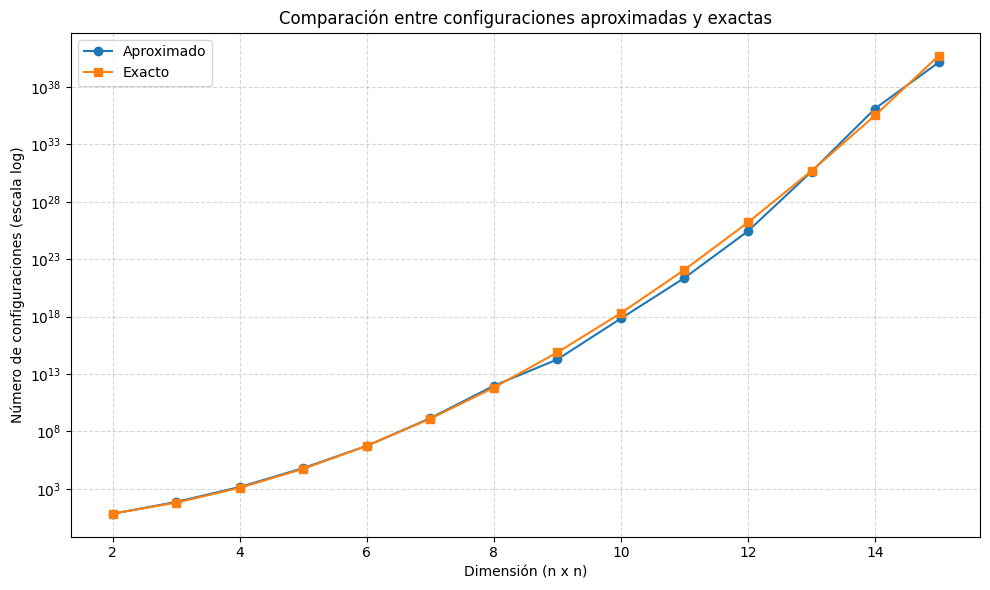

In [41]:
import pandas as pd
dims = np.arange(2, 16)  # 2 to 17

# Valores aproximados (los que me diste)
approx_values = np.array([
    6.7,
    72.8,
    1444.8,
    64295.9,
    5525527.3,
    1443558047.5,
    951286414073.8,
    189030653966917.5,
    691599757640581120.0,
    2373482165990338330624.0,
    28196615817169509252333568.0,
    4311425132096001172574641848320.0,
    1331661159409247708564178020702617600.0,
    13795976302719700716009855382427361345536.0,
])

# Valores exactos conocidos (hasta 16x16)
exact_values = np.array([
    7,
    63,
    1234,
    55447,
    5598861,
    1280128950,
    660647962955,
    770548397261707,
    2030049051145980050,
    12083401651433651945979,
    162481813349792588536582997,
    4935961285224791538367780371090,
    338752110195939290445247645371206783,
    52521741712869136440040654451875316861275,
])

print(len(approx_values), len(exact_values))

# Tabla comparativa
df = pd.DataFrame({
    "Dimensión": [f"{n}x{n}" for n in dims],
    "Aproximado": approx_values,
    "Exacto": exact_values
})

print(df)

# Gráfica en escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(dims, approx_values, marker="o", label="Aproximado")
plt.plot(dims, exact_values, marker="s", label="Exacto")
plt.yscale("log")
plt.xlabel("Dimensión (n x n)")
plt.ylabel("Número de configuraciones (escala log)")
plt.title("Comparación entre configuraciones aproximadas y exactas")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Conteo exacto por fuerza bruta:

In [25]:
import itertools

def vecinos(i, j, n):
    """Devuelve los vecinos (arriba, abajo, izquierda, derecha) de (i, j) en una rejilla n x n."""
    dirs = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for di, dj in dirs:
        ni, nj = i + di, j + dj
        if 0 <= ni < n and 0 <= nj < n:
            yield ni, nj

def es_factible(config, n):
    """Verifica si una configuración (tupla de 0s y 1s) cumple el modelo hard-core."""
    for i in range(n):
        for j in range(n):
            if config[i * n + j] == 1:
                # Si hay un ocupado, ninguno de sus vecinos puede estar ocupado
                for ni, nj in vecinos(i, j, n):
                    if config[ni * n + nj] == 1:
                        return False
    return True

def contar_configuraciones(n):
    """Cuenta todas las configuraciones factibles para un lattice n x n."""
    total_factibles = 0
    for config in itertools.product([0, 1], repeat=n * n):
        if es_factible(config, n):
            total_factibles += 1
    return total_factibles

# Ejemplo:
for n in range(1, 6):
    print(f"n = {n}, configuraciones factibles = {contar_configuraciones(n)}")


n = 1, configuraciones factibles = 2
n = 2, configuraciones factibles = 7
n = 3, configuraciones factibles = 63
n = 4, configuraciones factibles = 1234
n = 5, configuraciones factibles = 55447
